In [1]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using Statistics
import ProgressMeter
using Optim

In [6]:
data_seed, params_seed = 42, 120

(42, 120)

In [7]:
import ReactiveMP.messageout

In [8]:
include("../helpers/data.jl")

generate_data

In [9]:
function NN(y_,u_,θ)
    W1, b1 = reshape(θ[1:10],(5,2)), θ[11:15]
    W2, b2 = θ[16:20], θ[end]
    x = tanh.(W1*[y_;u_] .+ b1)
    W2'x + b2
end

melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [10]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [11]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    
    dim = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end] # TODO: fix
    
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(w_prior[1], w_prior[2]))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    neural_out = [NN(y_prev[i], u[i], params_f) for i in 1:n] #TODO: fix

    # create meta for AR
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + neural_out[t]
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        h_prev = h[t]
    end

    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [12]:
function nonlinear_max_inference(observations, observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(2), 0.1*diageye(2)), w_prior=(1.0, 1.0), vmp_its=1)
    # fetch number of samples
    n = length(observations)
    params_w = params[end-1:end]

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, model_flow, params[1:end-2], h_prior,
                                                                            w_prior, observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(melu(params_w[1]), melu(params_w[2])))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), diageye(dim)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [13]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [14]:
Random.seed!(data_seed)

n_samples = 100
u = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 2, 2, 2
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [15]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[order_u:end];

In [16]:
train_size = 80
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

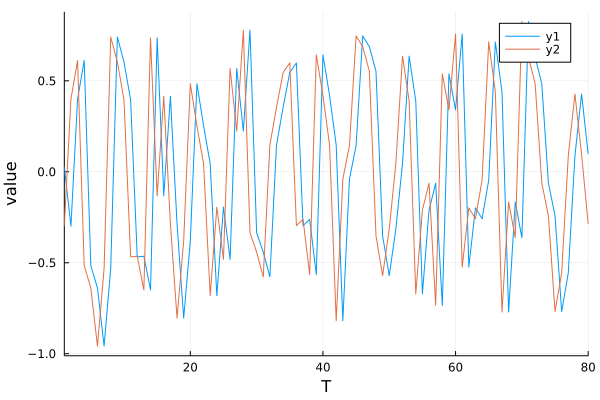

In [17]:
from, to = 1, 80
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value")

In [18]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
NN_param_len = 21
all_params = [randn(flow_param_len+NN_param_len); [10, 10]]; #Flow, NN, Gamma

In [21]:
fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, all_params, vmp_its=5);

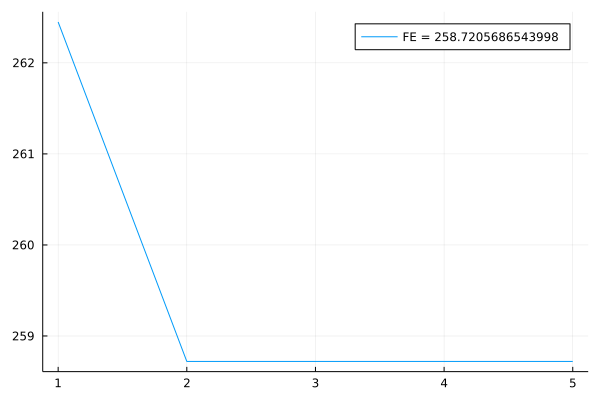

In [22]:
gr()
plot(fe, label="FE = $(fe[end])")

In [23]:
# Optimization function
function FE(params)
    fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(zeros(2), 0.001*diageye(2)), 
                                                 vmp_its=1)
    return fe[end]
end;

In [24]:
FE(all_params)

266.9317459908448

In [235]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_nn_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [0.424182, -0.544779, 0.674359, -1.71439, 0.589744, 0.981843,…

In [54]:
res = optimize(FE, all_params, GradientDescent(), Optim.Options(g_tol = 1e-12, iterations = 2000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)


Iter     Function value   Gradient norm 
     0     2.669317e+02     7.672461e+01
 * time: 9.679794311523438e-5
    10     1.779931e+02     5.301979e+01
 * time: 1.8016438484191895
    20     1.624092e+02     1.235569e+01
 * time: 3.287639856338501
    30     1.605365e+02     7.656896e+00
 * time: 4.7690370082855225
    40     1.590719e+02     7.012694e+00
 * time: 6.27144193649292
    50     1.570153e+02     5.639875e+00
 * time: 7.730896949768066
    60     1.545686e+02     5.458685e+00
 * time: 9.186769008636475
    70     1.537014e+02     3.945011e+00
 * time: 10.562700033187866
    80     1.531464e+02     3.723041e+00
 * time: 11.913757801055908
    90     1.527243e+02     3.549712e+00
 * time: 13.135438919067383
   100     1.523647e+02     3.414915e+00
 * time: 14.524394989013672
   110     1.520460e+02     3.275768e+00
 * time: 15.919684886932373
   120     1.517596e+02     3.086649e+00
 * time: 17.28555393218994
   130     1.514958e+02     2.836381e+00
 * time: 18.6788899898529

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.352864e+02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 3.33e-16 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.48e-17 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.36e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.01e-14 ≰ 0.0e+00
    |g(x)|                 = 1.25e+00 ≰ 1.0e-12

 * Work counters
    Seconds run:   1142  (vs limit Inf)
    Iterations:    2000
    f(x) calls:    19626
    ∇f(x) calls:   19626


In [55]:
inf_params = Optim.minimizer(res)

32-element Vector{Float64}:
 -2.441235397580506
  1.8188674659602189
  0.049016309754740514
 -2.289168753761511
  1.2362116923325719
  0.0353955172830913
  2.938017653104801
 -0.5192475151133822
  0.007659001960157736
 -0.23109754344360925
 -0.46843453955372116
  0.36216121500344295
  1.7907382822694125
  ⋮
 -0.754852755992189
  0.46561258455202786
  1.2813537272942535
 -0.9105915933555695
 -0.466397949430777
  0.44557477320680383
  0.8189849290589114
  0.21362931791922332
 -0.5458797116261446
 -0.37412820667019886
  4.533321766848207
 13.419498192723408

In [56]:
using JLD
JLD.save("../dump/flow_nn_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [57]:
FE(inf_params)

135.2862977161708

In [58]:
fe_inf, h_inf, w_inf, y_out_inf, θ_inf = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=10);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


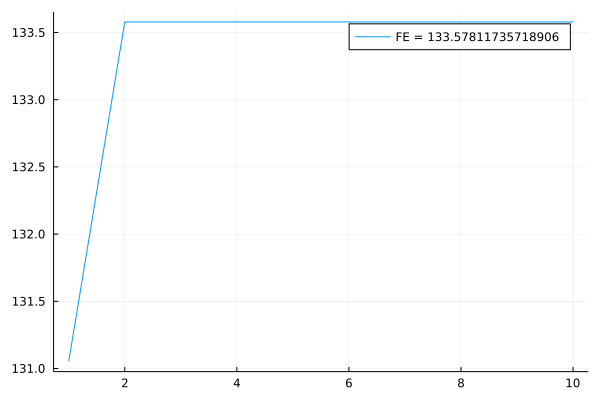

In [59]:
plot(fe_inf[1:end], label="FE = $(fe_inf[end])")

In [60]:
from, to = 1, 80

(1, 80)

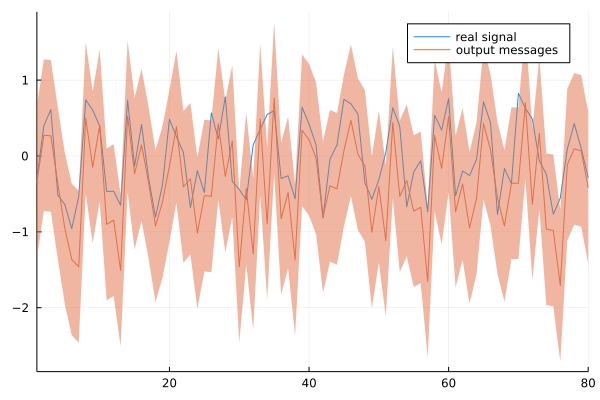

In [61]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

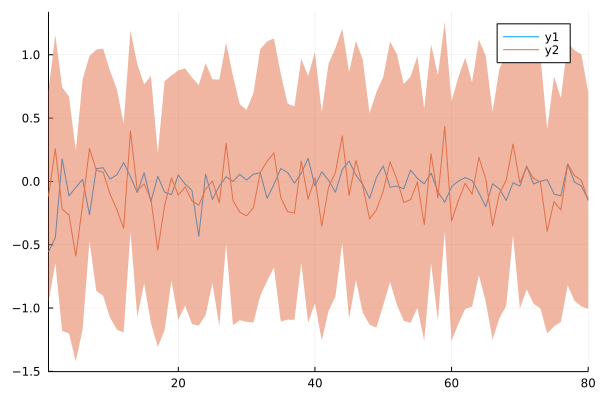

In [62]:
mh, vh = mean.(h_inf), cov.(h_inf)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [63]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [64]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    A = shift(dim) # transition matrix
    V = transition(w, dim)

    # initialize variables
    y_pred   = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    NN_pred = NN(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + NN_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w) where { q = q(y, y_lat_3)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [65]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 1) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(model_flow, params, w, h_prior,
                                                                                                    observation_prev, control,
                                                                                                    options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [66]:
predictions = []
h_prev = (mean(h_inf[end]), precision(h_inf[end]))
ŵ = inf_params[end-1]/inf_params[end]
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, vmp_its=1);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [67]:
mx, vx = mean.(predictions), cov.(predictions)

([0.0014829235186168666, -0.04142266692020477, -0.04627951058562106, 0.32499494746655366, -0.028685570258261645, 0.052789152593509886, -0.30930619221605926, -0.12180043175910665, -0.11937839126559033, 0.4074833032048691  …  -0.04991255994870434, -0.24082097085547477, -0.09519688817344298, -0.019782448487739412, 0.2445619080136967, 0.1294392564642852, -0.13852981692908267, -0.12138719924202825, 0.030940531520409313, -0.09600003839595307], [2.977518148466856, 3.010735269133448, 3.010963973535352, 3.0268118046546864, 3.0165153996573157, 3.0257474673634532, 3.0256872252138525, 3.0219190371160103, 3.059995243803924, 3.016907730416809  …  3.0118947679480286, 3.0312528702923234, 3.01006290590826, 3.0165160825902646, 3.0130555765670266, 3.0151947499880136, 3.0163017238996246, 3.010893451839165, 3.0162544556073616, 3.0610403150106644])

In [68]:
test_from, test_to = 1, 20

(1, 20)

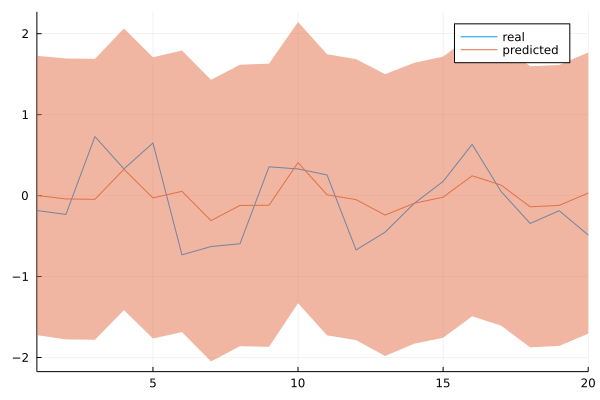

In [69]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")

In [70]:
n_output = [NN(y_prev, u, inf_params[13:end]) for (y_prev, u) in zip(X_test, U_test)]

21-element Vector{Float64}:
 23.77664089853991
 22.598595138992255
 22.69102413545961
 15.655387722260423
  9.527348693748129
  8.383050654265972
 24.139997405928725
 22.387287392706796
 22.402690015086304
 23.738728518017517
 11.192513359896711
  9.830745296649193
 26.04109973662571
 22.565539333896975
 22.6320673577222
 24.208099272911404
 10.926275065540647
 10.980754607335449
 23.727481258953883
 23.36901432591603
 22.452870051928613

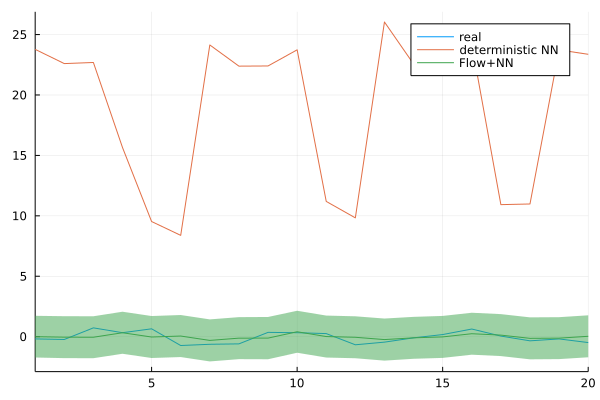

In [71]:
plot(Y_test, label="real")
plot!(n_output, label="deterministic NN")
plot!(mx, ribbon=sqrt.(vx), label="Flow+NN", xlims=(test_from, test_to))